In [21]:
import numpy as np
from matplotlib import pyplot as plt
import csv

In [22]:
rows    = 321
columns = 265
pixels  = rows * columns
W       = 10

In [23]:
def get_image_data():
    """ Returns the vector representation of the image. """
    with open("img.csv") as f:
        reader = csv.reader(f, delimiter=',')
        data = np.zeros(pixels, dtype=bool)
        for i, row in enumerate(reader):
            for j, value in enumerate(row):
                data[i * columns + j] = True if value == "1" else False
        return data

def get_pairs():
    """ Returns the neighbouring pairs of pixels. """
    pairs = set()
    for i in range(pixels):
        for j in get_neighbours(i):
            if (i, j) not in pairs and (j, i) not in pairs:
                pairs.add((i, j))
    return pairs

def get_neighbours(x, include_secondary=False):
    """ Returns the indices of the pixels neighbouring the pixel at index x.
    The neighbours are considered to be the pixel which are not just above,
    below, to the left and right, but also the four ones in the corners. """
    primary, secondary = set(), set()
    if x == 0:
        # Top left corner
        primary = {1, columns}
        secondary = {1, columns, columns + 1}
    elif x == columns - 1:
        # Top right corner
        primary = {x - 1, x + columns}
        secondary = {x + columns - 1}
    elif x == pixels - columns:
        # Bottom left
        primary = {x + 1, x - columns}
        secondary = {x - columns + 1}
    elif x == pixels - 1:
        # Bottom right
        primary = {x - 1, x - columns}
        secondary = {x - columns - 1}
    elif x < columns:
        # Top row
        primary = {x - 1, x + 1, x + columns}
        secondary = {x + columns - 1, x + columns + 1}
    elif x > pixels - columns:
        # Bottom row
        primary = {x - 1, x + 1, x - columns}
        secondary = {x - columns - 1, x - columns + 1}
    elif x % columns == 0:
        primary = {x - columns, x + columns, x + 1}
        secondary = {x + columns + 1, x - columns + 1}
    elif (x + 1) % columns == 0:
        # right column
        primary = {x - columns, x + columns, x - 1}
        secondary = {x + columns - 1, x - columns - 1}
    else:
        primary = {x - columns, x + columns, x - 1, x + 1}
        secondary = {x + columns - 1, x + columns + 1, x - columns - 1, x - columns + 1}
    if not include_secondary:
        return primary
    else:
        return primary.union(secondary)

In [24]:
noisy_img = get_image_data()
clean_img = get_image_data()

def plot_images():
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 2, 1)
    img = noisy_img.reshape((rows, columns))
    img = plt.imshow(img, cmap="gist_gray")
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    img = clean_img.reshape((rows, columns))
    img = plt.imshow(img, cmap="gist_gray")
    plt.axis('off')
    plt.show()

In [25]:
def obj():
    """ Returns the value of the objective function for the current state
    of the noisy image and clean image. """
    obj = 0
    for i in range(pixels):
        obj += (2 * noisy_img[i] - 1) * clean_img[i]
    for pair in get_pairs():
        obj += W if clean_img[pair[0]] == clean_img[pair[1]] else 0
    return obj

def updated_obj(obj, i):
    """ Returns the value of the objective function should the i-th pixel be the
    other value given the current value of the objective function. This is achieved
    by subtracting the contribution of pixel i for the value it has at first, flips
    the value and adds the contribution back.
        
    This is evidently better since when a pixel flips there is no need to recompute
    the whole objective, but only the difference that flipping a single pixel
    creates. """
    obj -= (2 * noisy_img[i] - 1) * clean_img[i]
    obj += (2 * noisy_img[i] - 1) * (not clean_img[i])
    for j in get_neighbours(i):
        obj -= W if clean_img[i] == clean_img[j] else 0
        obj += W if (not clean_img[i]) == clean_img[j] else 0
    return obj    

In [26]:
def clean():
    """ Cleanes an image by repeadetly starting a loop for each pixel (every time)
    in a random order and flipping each pixel to determine whether it improved the
    objective. It returns the objective once it has converged. """
    objective = obj()
    values = []
    while True:
        values.append(objective)
        r = np.arange(pixels - 1)
        np.random.shuffle(r)
        round_objective = objective
        for i in r:
            new_objective = updated_obj(round_objective, i)
            if new_objective > round_objective:
                round_objective = new_objective
                clean_img[i] = not clean_img[i]
        plot_images()
        if objective == round_objective:
            return np.array(values)
        else:
            objective = round_objective
            print(objective)

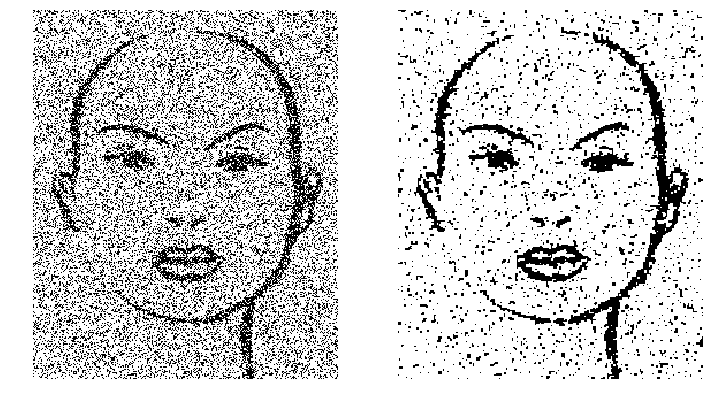

1584766


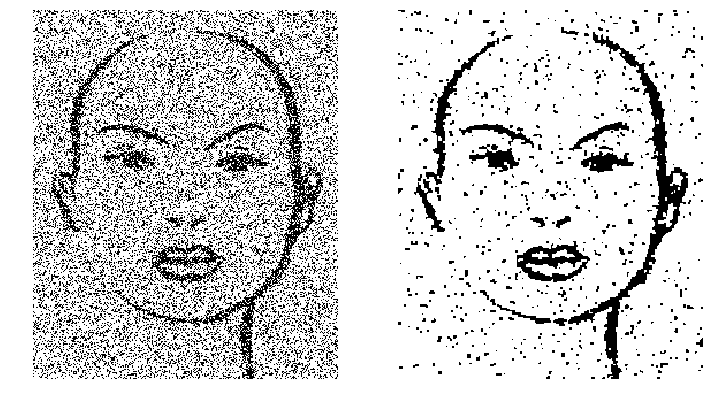

1642462


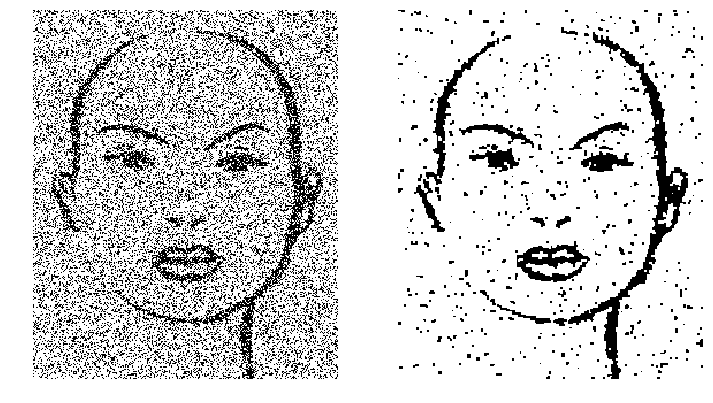

1655642


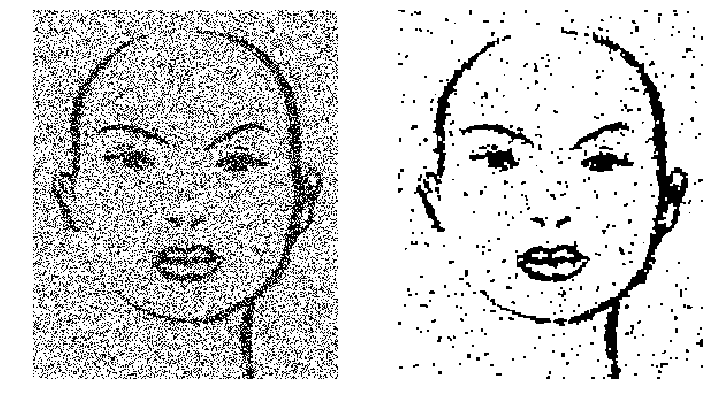

1659550


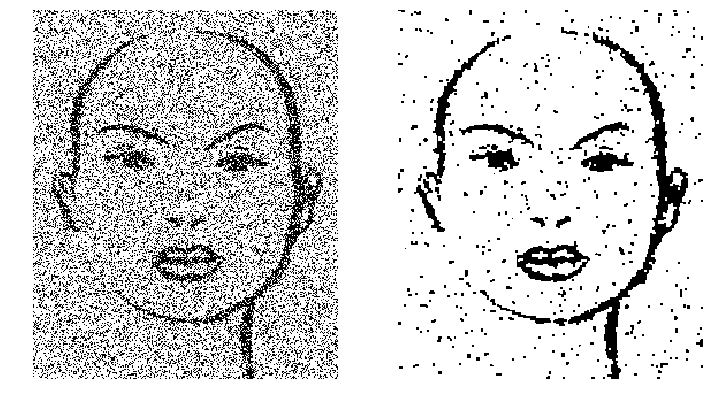

1660911


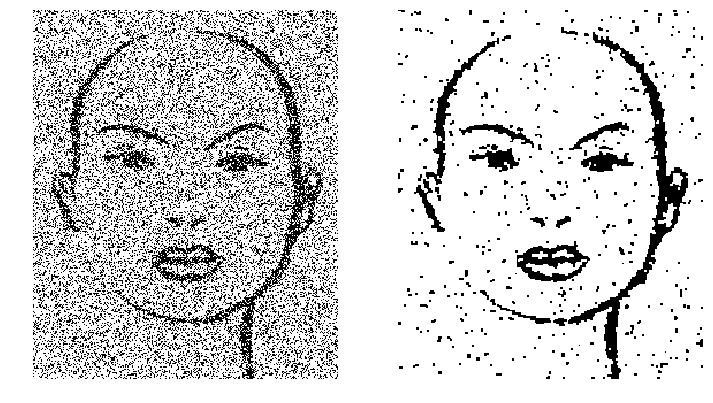

1661627


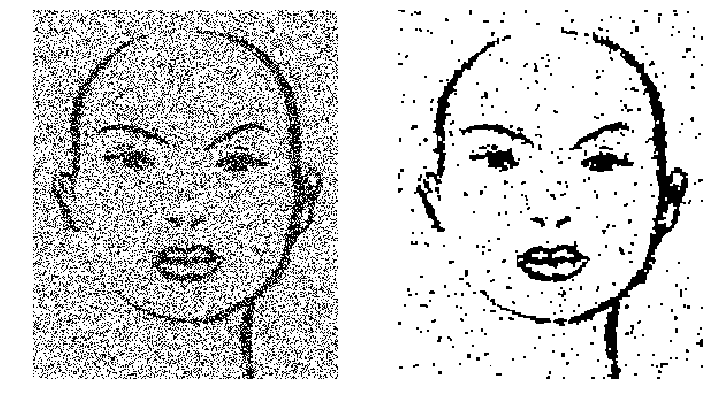

1661956


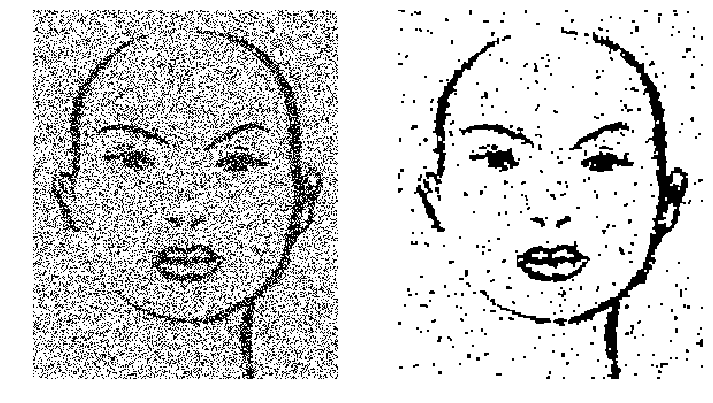

1662015


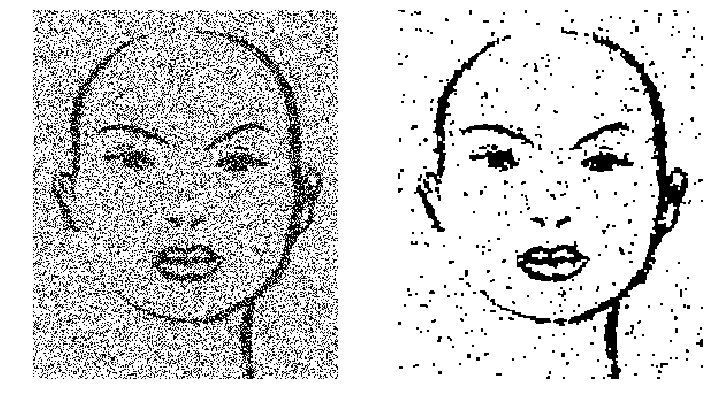

1662034


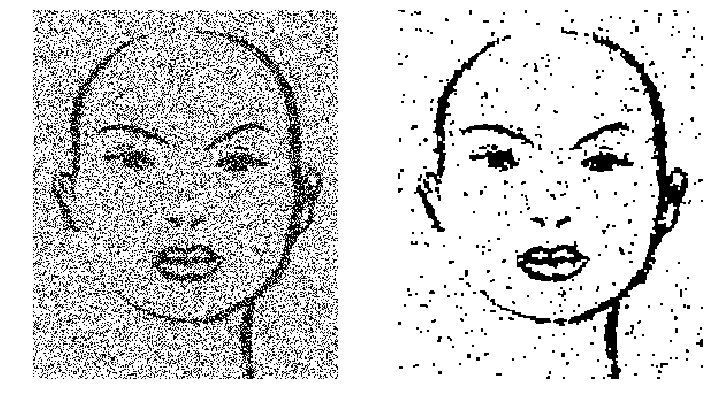

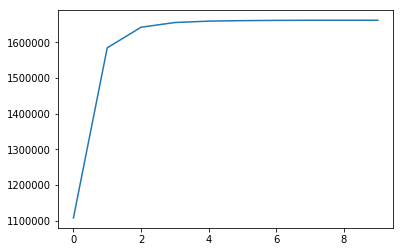

In [27]:
values = clean()
plt.plot(values)
plt.show()

In [28]:
values

array([1108183, 1584766, 1642462, 1655642, 1659550, 1660911, 1661627,
       1661956, 1662015, 1662034])

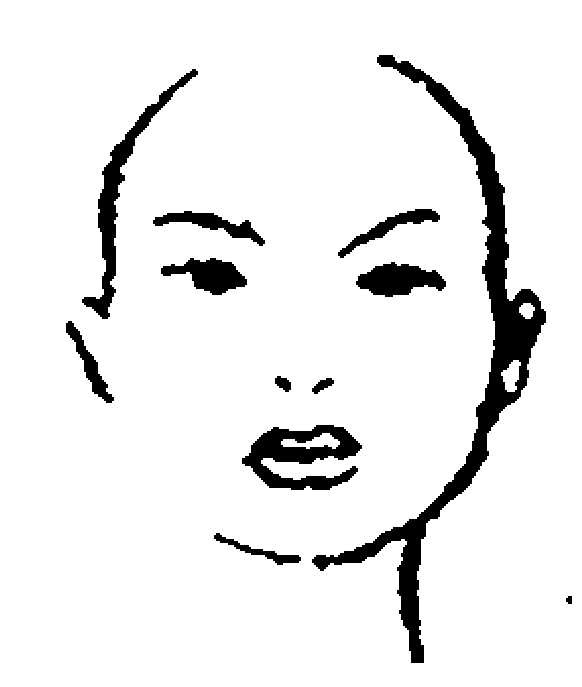

In [19]:
fig = plt.figure(figsize=(12, 12))
img = clean_img.reshape((rows, columns))
img = plt.imshow(img, cmap="gist_gray")
plt.axis('off')
plt.savefig("clean_secondary.png")